In [ ]:
# Будемо працювати з датасетом WMT 2016. Це набір даних для машинного перекладу. Основна ціль цього датасету полягає в перекладі англійських речень, що описують зображення, німецькою мовою. Або навпаки.
# Навчальна вибірка містить 29 000 прикладів, валідаційна — 1 014. Кожен приклад містить англійське речення та його переклад німецькою мовою, виконаний людиною.
# У якості тестових даних автори надали новий набір з 1 000 прикладів, що містять тільки англійський опис.
#  Для виконання завдання нам знадобляться мовні моделі бібліотеки spacy. Завантажте їх наступною командою з терміналу або з jupyter notebook, додавши ! перед командою.
! python3 -m spacy download en
! python3 -m spacy download de

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 74.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependenc

In [ ]:
!pip install update torch==2.0.1
!pip install torchtext==0.15.2
!pip install datasets==2.14.7
!pip install evaluate==0.4.0
!pip install torchvision==0.15.2

In [ ]:
import os
import random
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
import de_core_news_sm

import datasets
import torchtext

import torch
import torch.nn as nn
import torch.optim as optim

import evaluate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# set random seed / Для забезпечення відтворюваності результатів.
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
# Завантажимо наш набір даних, використовуючи бібліотеку datasets від HuggingFace.
dataset = datasets.load_dataset("bentrevett/multi30k")

In [ ]:
dataset  # Виклик об’єкта DatasetDict одразу дає нам зрозуміти обсяги набору даних та ознаки, якими він представлений.

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [ ]:
# Розділимо дані на навчальні й тестувальні.
train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]

train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

Отже, кожен елемент набору даних — це словник із ключами ['en', 'de'] та значеннями, що відповідають англійському та німецькому перекладам речення.

# Попередня обробка даних

In [ ]:
with pd.option_context('display.max_colwidth', None):
    example_df = pd.DataFrame(train_data[:5])
    display(example_df)

,en,de
0,"Two young, White males are outside near many bushes.",Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
1,Several men in hard hats are operating a giant pulley system.,Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus aus Holz.
3,A man in a blue shirt is standing on a ladder cleaning a window.,Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [ ]:
en_nlp = en_core_web_sm.load()
de_nlp = de_core_news_sm.load()

In [1]:
# Завантажимо мовні моделі бібліотеки spicy. Ми будемо використовувати їх для попередньої обробки наших даних.
# Першим кроком роботи з нашою послідовністю буде її токенізація.

# Зверніть увагу на параметр max_length.
# Встановлення максимального розміру вхідної послідовності дозволяє уникнути надто довгих речень, які можуть призвести до надмірного використання пам'яті та обчислювальних ресурсів.
# Це особливо важливо для моделей, які обробляють фіксовану довжину вхідних даних. Приведення вхідних речень до однакової або меншої довжини також спрощує роботу з батчами даних.
# Довгі речення можуть містити багато шуму чи нерелевантної інформації, що може вплинути на якість навчання моделі.
# Обмежуючи довжину речень, ми зменшуємо ризик перенавчання моделі на надмірно довгих послідовностях.

def tokenize_example(
    example,
    en_nlp,
    de_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    '''
    Tokenizes a textual English-German input pair.
    Args:
        example: (dict) a dictionary with one phrase in English and German; keys 'en', 'de'
        en_nlp: (spacy.lang) a spacy language model for English
        de_nlp: (spacy.lang) a spacy language model for German
        max_length: (int) max input sentence length, symbols
        lower: (bool) if to lowercase input
        sos_token: (str) a start_of_sequence token
        eos_token: (str) an end_of_sequence token

    Return:
        (dict) pre-processed and tokenized input sequence
    '''
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [ ]:
# Pre-process input data

max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [ ]:
# Creating a vocab / Створимо словник для нашого набору даних.

min_freq = 2 # minimum frequency of occurrence in the text
unk_token = "<unk>" # unknown token
pad_token = "<pad>" # padding token

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(unk_index)
print(pad_index)

print(en_vocab['the'])

0
1
7


In [ ]:
# Setting default value for oov words  / Встановимо значення за замовчуванням для out-of-vocabulary слів.

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [ ]:
# Приведемо наші дані в числову форму.
def numericalize_example(example, en_vocab, de_vocab):
    '''
    Creates a mapping from string tokens to the vocabulary indexes.
    '''
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [ ]:
fn_kwargs = {
    "en_vocab": en_vocab,
    "de_vocab": de_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
train_data[0]

{'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>'],
 'en_ids': [2, 16, 24, 15, 25, 778, 17, 57, 80, 202, 1312, 5, 3],
 'de_ids': [2, 18, 26, 253, 30, 84, 20, 88, 7, 15, 110, 7647, 3171, 4, 3]}

# Dataset і DataLoader

In [ ]:
# Data to torch Dataset format / Перетворимо наші набори даних у тип Dataset.

data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [ ]:
train_data

Dataset({
    features: ['en', 'de', 'en_tokens', 'de_tokens', 'en_ids', 'de_ids'],
    num_rows: 29000
})

In [ ]:
train_data[0]

{'en_ids': tensor([   2,   16,   24,   15,   25,  778,   17,   57,   80,  202, 1312,    5,
            3]),
 'de_ids': tensor([   2,   18,   26,  253,   30,   84,   20,   88,    7,   15,  110, 7647,
         3171,    4,    3]),
 'en': 'Two young, White males are outside near many bushes.',
 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'en_tokens': ['<sos>',
  'two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.',
  '<eos>'],
 'de_tokens': ['<sos>',
  'zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.',
  '<eos>']}

In [ ]:
# Якщо Dataset повертає дані інших типів, ніж тензори, масиви, числа, словники або списки, необхідно повторно викликати collate_fn.
# Після отримання списку прикладів за індексами із семплера функція, передана як аргумент collate_fn, використовується для зіставлення списків прикладів у батчі.

# Наша collate_fn буде додавати падинг до вхідних послідовностей, щоб отримувати батчі даних сталої розмірності.
def get_collate_fn(pad_index):
    '''
    Adding padding as a part of a collate_fn.
    '''

    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [ ]:
# Напишемо функцію для отримання DataLoader.
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):

    collate_fn = get_collate_fn(pad_index)

    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )

    return data_loader

In [ ]:
# Створимо об’єкти DataLoader і переглянемо, як буде виглядати один батч.
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
next(iter(train_data_loader))
# Тут ми не ставимо значення атрибута batch_first=True, тому батч має розмірність (seq_len, batch_size).
# Бачимо, що всі послідовності мають одну довжину, і коротші послідовності подовжено за допомогою <pad>, тобто його чисельної репрезентації — 1

{'en_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [   4,    9,    4,  ...,    4,    9,    4],
         [ 719, 1041,   59,  ...,    9,   22,    9],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]]),
 'de_ids': tensor([[   2,    2,    2,  ...,    2,    2,    2],
         [   8,    5,    8,  ...,    5,    5,    5],
         [1058,   13,  168,  ...,   13,   13,   13],
         ...,
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   1,    1,    1,  ...,    1,    1,    1]])}

# Model building / Практика. Клас моделі

In [ ]:
# Настав час визначити клас моделі, а саме — її основні компоненти: енкодер, декодер, механізм уваги та загальний клас seq2seq.
# Архітектура енкодера нам уже знайома: шар ембедингів, рекурентна мережа, повнозв’язний шар (fully connected layer) і функція активації.
# Для пришвидшення розрахунків будемо використовувати модель GRU. Для кращого опрацювання вхідних даних використаємо двонаправлену версію моделі.

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, src): # (src_length, batch size)
        embedded = self.dropout(self.embedding(src)) # (src_length, batch_size, embedding_dim)

        outputs, hidden = self.rnn(embedded)
        # outputs (src_length, batch_size, hidden dim * n_directions)
        # hidden (n_layers * n_directions, batch_size, hidden dim)

        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]

        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN

        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        # outputs (src_length, batch_size, encoder_hidden_dim * 2)
        # hidden (batch_size, decoder_hidden_dim)

        return outputs, hidden

Власноруч побудуємо клас механізму уваги.
__init__


* encoder_hidden_dim і decoder_hidden_dim визначають розміри прихованих станів енкодера і декодера.
* self.attn_fc — повнозв’язний шар, який з'єднує приховані стани декодера та виходи енкодера. Вхідна розмірність цього шару — сума подвоєної розмірності прихованих станів енкодера й розмірності прихованого стану декодера, вихідна розмірність — розмірність прихованого стану декодера.
* self.v_fc — лінійний шар, який зменшує розмірність до 1, щоб обчислити значення уваги.


###Метод forward()

* hidden — поточний прихований стан декодера розмірності (batch_size, decoder_hidden_dim).
* encoder_outputs — виходи енкодера розмірності (src_length, batch_size, encoder_hidden_dim * 2).


Повторення та зміна форми

* hidden.unsqueeze(1).repeat(1, src_length, 1): : прихований стан декодера повторюється src_length разів, щоб мати однакову довжину з виходами енкодера.
* encoder_outputs.permute(1, 0, 2): змінюється форма виходів енкодера для відповідності розмірностям (batch_size, src_length, encoder_hidden_dim * 2).


Обчислення енергії та уваги

👉🏻 Термін «енергія» стосується скалярного значення, яке визначає ступінь важливості кожного елемента вхідної послідовності (зокрема, виходів енкодера) для поточного кроку декодера. Це значення використовується для обчислення ваг уваги (attention weights).


* torch.cat((hidden, encoder_outputs), dim=2): конкатенуються прихований стан декодера й виходи енкодера уздовж останньої осі (розмірність буде (batch_size, src_length, (encoder_hidden_dim * 2) + decoder_hidden_dim)).
* self.attn_fc — проходження через лінійний шар і застосування активації tanh, що дає енергію розмірності (batch_size, src_length, decoder_hidden_dim).
* self.v_fc(energy).squeeze(2) — застосування другого лінійного шару для отримання скалярних значень уваги і зміна форми до (batch_size, src_length).
* torch.softmax(attention, dim=1) — нормалізація значень уваги уздовж осі довжини послідовності (src_length) за допомогою softmax, щоб отримати ймовірності.

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim,
            decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1) # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2) # (batch_size, src_length, encoder_hidden_dim * 2)

        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2) # batch_size, src_length

        return torch.softmax(attention, dim=1)

In [ ]:
# Декодер у свою чергу приймає прихований стан енкодера.
# Тут архітектура подібна до архітектури енкодера з додаванням механізму уваги та ряду перетворень (використання permute() і cat()),
# щоб після його застосування подати на вхід рекурентної мережі значення коректної розмірності.
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim,
            output_dim
        )
        self.dropout = nn.Dropout(0.5)

    def forward(self, input, hidden, encoder_outputs):
        # input = (batch_size)
        # hidden = batch_size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs) # batch matrix-matrix product
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)


In [ ]:
# Клас Seq2Seq у методі forward() почергово пропускає дані спочатку через енкодер, а потім циклом кожен токен через декодер.

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

# Тренування моделі

In [ ]:
# Визначимо основні гіперпараметри моделі.
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = '/'

In [ ]:
# Визначимо об’єкт моделі:
attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    attention,
)


model = Seq2Seq(encoder, decoder, device).to(device)

model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# Ініціюємо ваги моделі з нормального розподілу.
# У нормальному розподілі ваги можуть бути частиною нормального або гаусівського розподілу з нульовим середнім значенням та одиничним стандартним відхиленням.
# Випадкова ініціалізація робиться для того, щоб збіжність не досягала хибного мінімуму.

def init_weights(m):
    """
    Initiates model weights from the normal distribution.
    Sets bias to 0.
    """
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# Визначимо оптимізатор і функцію втрат.
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [ ]:
# Визначимо функції для тренування й тестування моделі.
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()
    epoch_loss = 0
    for i, batch in tqdm(enumerate(data_loader)):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0) #turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [ ]:
#  У глибоких нейронних мережах або при використанні великих навчальних коефіцієнтів градієнти можуть ставати дуже великими,
# що призводить до нестабільного навчання. Таке явище називають вибухаючим градієнтом (exploding gradient).
# Обрізання градієнтів (gradient clipping) обмежує їхню величину до певного порогу, запобігаючи цьому явищу.
# При обрізанні градієнтів за допомогою clip_grad_norm_ значення градієнтів обмежуються так, щоб їхня норма не перевищувала заданий поріг.
# Це означає, що якщо сукупна величина градієнтів (їхня норма) перевищує встановлений поріг, вони будуть масштабовані назад до цього порогу, зберігаючи напрямок, але зменшуючи величину.

n_epochs = 10
clip = 1.0 # gradient clipping
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):

    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )

    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'en_fr.pt'))

    print(f"\tTrain Loss: {train_loss:7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

	Train Loss:   5.042
	Valid Loss:   4.767


0it [00:00, ?it/s]

	Train Loss:   4.140
	Valid Loss:   4.332


0it [00:00, ?it/s]

	Train Loss:   3.493
	Valid Loss:   3.759


0it [00:00, ?it/s]

	Train Loss:   2.913
	Valid Loss:   3.422


0it [00:00, ?it/s]

	Train Loss:   2.524
	Valid Loss:   3.343


0it [00:00, ?it/s]

	Train Loss:   2.238
	Valid Loss:   3.313


0it [00:00, ?it/s]

	Train Loss:   1.963
	Valid Loss:   3.286


0it [00:00, ?it/s]

	Train Loss:   1.775
	Valid Loss:   3.310


0it [00:00, ?it/s]

	Train Loss:   1.604
	Valid Loss:   3.334


0it [00:00, ?it/s]

	Train Loss:   1.480
	Valid Loss:   3.429


Бачимо, що модель перенавчилась (overfitted) до навчальних даних. Виправити це можна інструментами регуляризації, які ми будемо проходити далі.

Поки протестуємо модель у її поточному стані.



# Тестування моделі


In [ ]:
# Завантажимо ваги моделі, що мала найнижче значення функції втрат на валідації.
# Розрахуємо loss на тестовому наборі даних.
model.load_state_dict(torch.load(os.path.join(model_dir, 'en_fr.pt'), map_location=device))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"Test Loss: {test_loss:.3f}")

Test Loss: 3.276


In [ ]:
# Значення функції втрат на тестовій вибірці зіставне зі значенням на валідаційній.

# Визначимо функцію, за допомогою якої будемо робити переклад.
# На початку токенізуємо вхідну послідовність і додамо токени <sos> та <eos>.
# Токени німецького речення перетворимо на індекси за допомогою словника та збережемо як тензори.

# Початковим вхідним токеном для декодера є <sos> для англійської мови.
# На кожному кроці в декодер передається поточний вхідний токен, прихований стан і вихідні значення енкодера.
#Отримуються передбачені вихідні значення, прихований стан і значення уваги моделі.
# Прогнозований токен додається до вхідних токенів для наступного кроку декодування.
# Якщо досягнуто токена <eos>, цикл завершується.

# Індекси англійських токенів конвертуються назад у текстові токени за допомогою словника.

# Повертаються токени англійського та німецького речень, обмежені до довжини англійського речення, і значення уваги моделі.

def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[:len(en_tokens)-1]

In [ ]:
# Додамо також функцію, яка буде візуалізувати значення уваги моделі.

def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(5,5))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [ ]:
# Переглянемо оригінальні речення й переклад.
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [ ]:
# Виконаємо переклад.
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print(translation)
print(sentence_tokens)

['<sos>', 'a', 'man', 'in', 'an', 'orange', 'hat', 'welding', 'something', '.', '<eos>']
['<sos>', 'ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.', '<eos>']


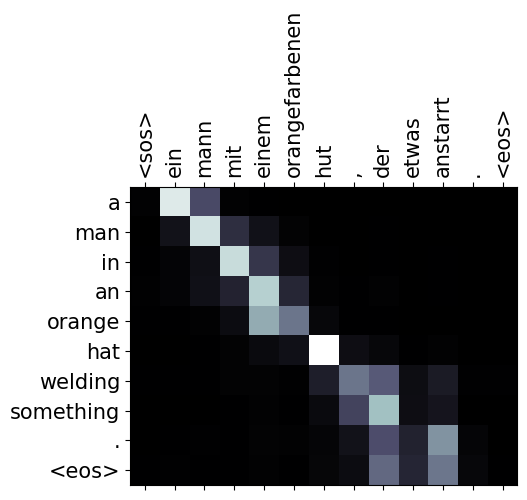

In [ ]:
# Візуалізуємо значення уваги моделі.
plot_attention(sentence_tokens, translation, attention)

З графіка видно, на які токени вхідної послідовності найбільше зверталось уваги під час генерації відповідних токенів вихідної послідовності.



💡 Поекспериментуйте та спробуйте перекласти інші речення з німецької англійською. Використовуйте речення з тестового набору даних або ж власні приклади.


Отже, ми успішно побудували й реалізували нашу першу модель для машинного перекладу на основі архітектури seq2seq з механізмом уваги.


